# ДЗ №7 Береснева Юлия

- Data set is "Meta-data Data Set" https://archive.ics.uci.edu/ml/datasets/Meta-data
- Relevant Information: 
> This DataSet is about the results of Statlog project. The project performed a comparative study between Statistical, Neural and Symbolic learning algorithms. 
- Number of Instances: 528
- Number of Attributes: 22
- Attribute Information:
 - `DS_Name` - Name of DataSet - название набора данных
 - `T` - Number of examples in test set - количество примеров в тестовом наборе
 - `N` - Number of examples - количесвто примеров
 - `p` - Number of attributes - количесвто атрибутов
 - `k` - Number of classes - количество классов
 - `Bin` - Number of binary Attributes - количество бинарных атрибутов
 - `Cost` - Cost ( `1 = yes`,`0 = no`) - стоимость
 - `SDratio` - Standard deviation ratio - коэффициент стандартного отклонения
 - `correl`- Mean correlation between attributes - средняя корреляция между атрибутами
 - `cancor1` - First canonical correlation - Первая каноническая корреляция
 - `cancor2` - Second canonical correlation - Вторая каноническая корреляция
 - `fract1` - First eigenvalue - первое собственное значение
 - `fract2` - Second eigenvalue - второе собственное значение
 - `skewness` - Mean of $ \frac{|E(x - Mean)|^3}{STD^3} $ - асимметрия -  среднее значение $ \frac{|E(x - Mean)|^3}{STD^3} $
 - `kurtosis` - Mean of $ \frac{|E(x - Mean)|^4}{STD^4} $ - среднее значение $ \frac{|E(x - Mean)|^4}{STD^4} $ 
 - `Hc` - Mean entropy of attributes - средняя энтропия атрибутов
 - `Hx`- Entropy of classes - энтропия классов
 - `MCx` - Mean mutual entropy of class and attributes - средняя взаимная энтропия класса и атрибутов
 - `EnAtr` - Equivalent number of attributes - Эквивалентное количество атрибутов
 - `NSRatio` - Noise-signal ratio - Отношение сигнал / шум
 - `Alg_Name` - Name of Algorithm -  имя алгоритма
 - `Norm_error` - Normalized Error (continuous class) - нормализованная ошибка (непрерывный класс)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
#url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/meta-data/meta.data'
#data = pd.read_csv(url, sep = ',', engine='python')
data = pd.read_csv('../source/meta1.data', sep = ',', engine = 'python')

Обрабатываем данные и подготавливаем `X` и `y`

In [3]:
X = data.drop(['DS_Name', 'correl', 'cancor2', 'fract2', 'Alg_Name'], axis = 1) # выбрасываем столбцы
y = data['Alg_Name']

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y.unique())
y_tr = le.transform(y)

# Principal Components Analysis (PCA)

Метод главных компонент используется уменьшения числа размерности исходных данных.
Рассмотрим его применение к нашим данным. Изначально имеем 18 столбцов - число критериев, равное начальной размерности данных.
Попробуем уменьшить размерность до 10

In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 10)
pca.fit(X)
pca_x = pca.transform(X)
pca_x.shape

(528, 10)

Разбиваем данные на тестовую и обучающую выборки

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_tr, test_size = 0.33, random_state = 7)

Используем классификатор _Gradient Boosted Trees_ с 30-ю деревьями

In [6]:
from sklearn.ensemble import GradientBoostingClassifier

GBT = GradientBoostingClassifier(n_estimators=30)
GBT.fit(X_train, y_train)
    
y_train_pred = GBT.predict(X_train)
y_test_pred = GBT.predict(X_test)
     
print(np.mean(y_train != y_train_pred), np.mean(y_test != y_test_pred))

0.124645892351 0.96


Судя по значениям ошибок на тестовой и обучающей выборке, наблюдается переобучение

Исследуем зависимость ошибки от числа используемых компонент.

Массив с числом главных компонент:

In [7]:
c_arr = np.arange(2,18,1)

Изменяя число используемых компонент, построим график зависимости

In [8]:
test_err_GBT = []
train_err_GBT = []

for c in c_arr:
    pca = PCA(n_components = c)
    pca.fit(X)
    X_pca = pca.transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y_tr, test_size = 0.33, random_state = 7)
    
    GBT = GradientBoostingClassifier(n_estimators=30)
    GBT.fit(X_train, y_train)
    
    y_train_pred = GBT.predict(X_train)
    y_test_pred = GBT.predict(X_test)
    
    train_err_GBT.append(np.mean(y_train != y_train_pred))
    test_err_GBT.append(np.mean(y_test != y_test_pred))

In [9]:
print(np.mean(y_train != y_train_pred), np.mean(y_test != y_test_pred))

0.116147308782 1.0


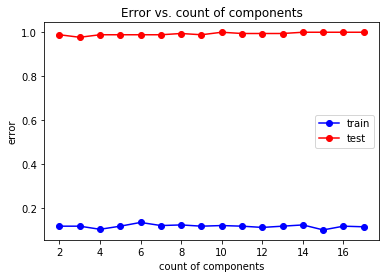

In [10]:
plt.plot(c_arr, train_err_GBT, 'b-o', label = 'train')
plt.plot(c_arr, test_err_GBT, 'r-o', label = 'test')

plt.title('Error vs. count of components')
plt.xlabel('count of components')
plt.ylabel('error')
plt.legend()
pass

Судя по полученным результатам, наблюдается переобучение - ошибка на тестовой выборке сильно больше, чем на обучающей
Также отметим, что изменение числа главных компонент слабо влияет на значение ошибки

Минимальные значения ошибок на обучающей и тестовой выборке

In [11]:
min_train_err = np.min(train_err_GBT)
min_test_err_GBT = np.min(test_err_GBT)
print(min_train_err, min_test_err_GBT)

0.101983002833 0.977142857143


Наилучшее число используемых компонент:

In [12]:
print(c_arr[test_err_GBT == min_test_err_GBT])

[3]


Исследуем зависимость ошибки от числа используемых компонент с использованием классификатора _AdaBoost_ с 20-ю деревьями

In [13]:
from sklearn.ensemble import AdaBoostClassifier

test_err_AB = []
train_err_AB = []
oob_err_AB = []

for c in c_arr:
    pca = PCA(n_components = c)
    pca.fit(X)
    X_pca = pca.transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y_tr, test_size = 0.33, random_state = 7)
    
    AB = AdaBoostClassifier(n_estimators = 20)
    AB.fit(X_train, y_train)
    
    y_train_pred = AB.predict(X_train)
    y_test_pred = AB.predict(X_test)
    
    train_err_AB.append(np.mean(y_train != y_train_pred))
    test_err_AB.append(np.mean(y_test != y_test_pred))

In [14]:
print(np.mean(y_train != y_train_pred), np.mean(y_test != y_test_pred))

0.923512747875 0.982857142857


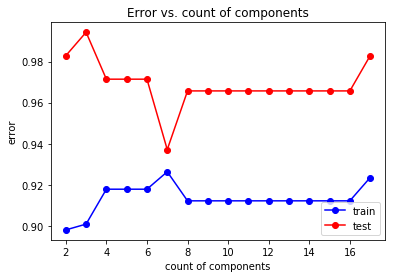

In [15]:
plt.plot(c_arr, train_err_AB, 'b-o', label = 'train')
plt.plot(c_arr, test_err_AB, 'r-o', label = 'test')
plt.title('Error vs. count of components')
plt.xlabel('count of components')
plt.ylabel('error')
plt.legend()
pass

Судя по полученным результатам, наблюдается недообучение - ошибка на тестовой и обучающей выборках сильно большая. Также отметим, что изменение числа главных компонент в малой степени влияет на значение ошибки

Минимальные значения ошибок на обучающей и тестовой выборке

In [16]:
min_train_err = np.min(train_err_AB)
min_test_err_AB = np.min(test_err_AB)
print(min_train_err, min_test_err_AB)

0.898016997167 0.937142857143


Наилучшее число используемых компонент:

In [17]:
print(c_arr[test_err_AB == min_test_err_AB])

[7]
